In [1]:
# Goal: predict the post's political leaning and subreddit based on title and selftext (Reddit dataset)

# Problem Type: multiclass, 2-label classification

# Model: Word Level LSTM with Word Embeddings

# Evaluation: accuracy, precision, recall, F1-score

# Setup Torch

In [2]:
import torch

device = torch.device('cpu')
# check if cuda is available
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f'Using {device}')

Using cuda


# Prepare the data

In [3]:
import re
import unicodedata
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# load the data
dataset = pd.read_csv('/kaggle/input/liberals-vs-conservatives-on-reddit-13000-posts/file_name.csv')
text, labels = dataset[['Title', 'Text']].copy(), dataset[['Political Lean', 'Subreddit']].copy()

# numerize the labels
leaning_encoder, subreddit_encoder = LabelEncoder(), LabelEncoder()
labels['Political Lean'], labels['Subreddit'] = leaning_encoder.fit_transform(labels['Political Lean']), subreddit_encoder.fit_transform(labels['Subreddit'])

# merge titles and selftexts. if theres no selftext, title will be the sole input
text = text.apply(lambda row: row['Title'] + ' ' + row['Text'] if pd.notna(row['Text']) else row['Title'], axis=1)

# simplify the vocabulary by turning unicode to ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim puntuation, remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    # add a space before the punctuation to treat it seperately from the word(s) its connected to
    s = re.sub(r"([.!?])", r" \1", s)
    # keep only a-z, ! and ? in the text
    s = re.sub(r"[^a-z!?]+", r" ", s)
    # remove trailing whitespaces
    return s.strip()


# apply the changes
sample_before = text[1981]
text = text.apply(lambda row: normalizeString(row))
sample_after = text[1981]

# sample comparison
print(f"Before - {sample_before}\n\nAfter - {sample_after}")

Before - Analysis: Here's a little math lesson for Ted Cruz on the Supreme Court - Lying Ted Cancun Cruz now needs a Math lesson from his kid, Ever since he cut his vacation short and came back with his tail between his legs, he's gone senile

After - analysis here s a little math lesson for ted cruz on the supreme court lying ted cancun cruz now needs a math lesson from his kid ever since he cut his vacation short and came back with his tail between his legs he s gone senile


# Analyze the word counts of the sequences

Summary statistics of word counts:
count    12854.000000
mean        49.827291
std        192.413926
min          1.000000
25%          9.000000
50%         13.000000
75%         24.000000
max       5916.000000
dtype: float64

90th, 95th and 99th percentiles of word counts:
[83.0, 182.0, 688.3499999999967]



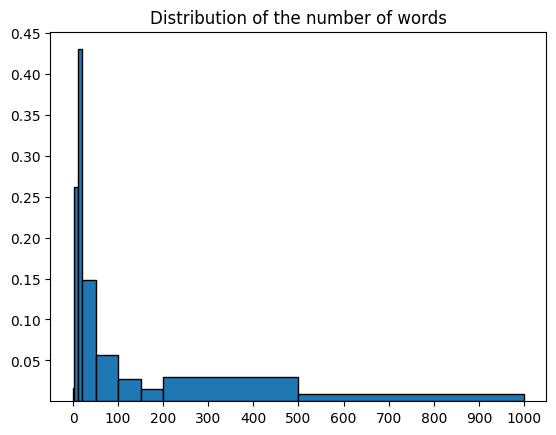

In [4]:
import matplotlib.pyplot as plt
import numpy as np

count = text.apply(lambda x: len(x.split(' ')))

print(f"Summary statistics of word counts:\n{count.describe()}\n")
print(f"90th, 95th and 99th percentiles of word counts:\n{[count.quantile(x) for x in (0.9, 0.95, 0.99)]}\n")

plt.title('Distribution of the number of words')
plt.hist(count, bins=[0, 3, 10, 20, 50, 100, 150, 200, 500, 1000], weights=[1 / len(count)] * len(count), edgecolor='black')
plt.xticks([x for x in np.arange(0, 1001, 100)])
plt.yticks([y for y in np.arange(0.05, 0.5, 0.05)])
plt.show()

It was decided to set a limit on number of words: 100. The main reasons/goals are:
--------
1) Speed up training
2) Prevent overfitting
3) The starting text is the most informative. Even if a small fraction of the data (8.74%) has more than 100 words, they can still be effectively classified
------
It was also decided to set a minimum word count of 3 to filter unclear titles

In [5]:
min_count = 3
max_count = 100

text_trim, labels_trim = text[count >= min_count].reset_index(drop=True), labels[count >= min_count].reset_index(drop=True)

sample_before = text_trim[78]
text_trim = text_trim.apply(lambda x: ' '.join(x.split(' ')[:max_count]))
sample_after = text_trim[78]

print(f"Summary statistics of sequence lengths after the cutting:\n\n{text_trim.apply(lambda x: len(x.split(' '))).describe()}\n\n")

print(f"Before: {sample_before}\n\nAfter: {sample_after}")

Summary statistics of sequence lengths after the cutting:

count    12643.000000
mean        25.174088
std         28.213046
min          3.000000
25%          9.000000
50%         13.000000
75%         25.000000
max        100.000000
dtype: float64


Before: sick of the west moralizing ! rant first things first no country has the right to invade another country countries don t have rights people have rights and an invasion is a fundamental violation of those rights russian soldiers should not be in ukraine killing ukrainian people that being said it s so fucking tone deaf to see what all of these people companies and countries are doing to russia because they invaded another country when the us has invaded and overthrown at least countries in the past two decades with the uk denmark poland and australia providing troops for these illegal invasions does anyone remember the dixie chicks being cancelled because they were anti war ? now suddenly american people and companies are cancellin

# Assign each word (token) a unique index. These indices will be used for assigning each word a dense vector, which is the representation of the word that is fed into the model.

In [6]:
def get_vocabulary(df):
    '''Form the vocabulary from the dataset. Each word will be assigned an index'''
    # padding token is assigned to 0, start of sequence token is assigned to 1, end of sequence token is assigned to 2
    vocab = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2}
    for s in df:
        for l in s.split(' '):
            if l not in vocab:
                vocab[l] = len(vocab)
    return vocab

VOCABULARY = get_vocabulary(text_trim)
print(f"The vocabulary of the dataset consists of {len(VOCABULARY)} tokens.\n")

text_numerized = text_trim.apply(lambda x: ([VOCABULARY['<SOS>']] + [VOCABULARY[l] for l in x.split(' ')] + [VOCABULARY['<EOS>']] +
                                            [VOCABULARY['<PAD>']]*(max_count - len(x.split(' ')))))
print(f"Before: {text_trim[1972]}\n\nAfter: {text_numerized[1972]}")

The vocabulary of the dataset consists of 20655 tokens.

Before: a cause of america s labor shortage millions with long covid

After: [1, 75, 1947, 21, 475, 38, 1842, 5317, 4221, 65, 239, 240, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Load GloVe6B50d - pretrained word embeddings

In [7]:
from torch import nn

# Load the pretrained embeddings from txt into a dictionary
def load_glove_embeddings(glove_file, vocab, embedding_dim):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in vocab:  # Only load embeddings for words in the vocabulary
                vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
                embeddings[word] = vector
            # Stop early if all vocab words are found
            if len(embeddings) == len(vocab):
                break
    return embeddings

# Initialize an embedding layer with the loaded GloVe embeddings
def initialize_embedding_layer(vocab, glove_embeddings, embedding_dim):
    voc_size = len(vocab)
    embedding_matrix = torch.zeros((voc_size, embedding_dim))
    # a counter to compute the OOV ratio (Out Of Vocabulary: how many words in our vocabulary werent covered by GloVe)
    c = 0
    for word, idx in vocab.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            embedding_matrix[idx] = torch.randn(embedding_dim)  # Random initialization for OOV words
            c += 1

    embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
    return embedding_layer, c / voc_size

glove_file = '/kaggle/input/glove6b50dtxt/glove.6B.50d.txt'
embedding_dim = 50

glove_embeddings = load_glove_embeddings(glove_file, VOCABULARY, embedding_dim) 
glove_layer, ratio = initialize_embedding_layer(VOCABULARY, glove_embeddings, embedding_dim)
# roughly 10% OOV rate
print(ratio)

0.09939481965625757


# The data is fully processed. Now it should be wrapped into tensor datasets for feeding into a neural network.

In [8]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class LibVsConDataset(Dataset):
    def __init__(self, text, labels):
        '''Pass the data that will form the Dataset instance'''
        self.text = text
        self.labels = labels
        
    def __len__(self):
        '''Measure of the size of the dataset'''
        return len(self.text)

    def __getitem__(self, idx):
        '''How a data point of the dataset is retrieved'''
        # we simply expand torch tensor indexing into the Dataset
        text, label = self.text[idx], self.labels[idx]
        return text, label

# split the dataset into training, validation and test sets with 0.7:0.15:0.15 ratio
text_train, text_notrain, labels_train, labels_notrain = train_test_split(text_numerized, labels_trim, test_size=0.3,
                                                                              stratify=labels_trim, random_state=42)

text_val, text_test, labels_val, labels_test = train_test_split(text_notrain, labels_notrain, test_size=0.5,
                                                                     stratify=labels_notrain, random_state=42)

# wrap the data into tensor datasets
text_train, labels_train = torch.tensor(text_train.tolist(), dtype=torch.long), torch.tensor(labels_train.values, dtype=torch.long)
text_val, labels_val = torch.tensor(text_val.tolist(), dtype=torch.long), torch.tensor(labels_val.values, dtype=torch.long)
text_test, labels_test = torch.tensor(text_test.tolist(), dtype=torch.long), torch.tensor(labels_test.values, dtype=torch.long)


# wrap the datasets into torch.utils.data.Dataset instances
train_dataset = LibVsConDataset(text_train, labels_train)
val_dataset = LibVsConDataset(text_val, labels_val)
test_dataset = LibVsConDataset(text_test, labels_test)

# Its time to build the Model Architecture: LSTM with Word Embeddings

In [9]:
from torch.nn.utils.rnn import pack_padded_sequence

class PoliticalClassifier(nn.Module):
    '''A neural network that classifies political leaning and subreddit of a text'''
    def __init__(self, embedding_layer, hidden_state_size, dense_size, output_size, dropout_rate=0.2):
        super().__init__()
        self.embedding = embedding_layer
        # the actual hidden size will be 2 * hidden_state_size
        self.lstm = nn.LSTM(input_size=embedding_layer.embedding_dim, hidden_size=hidden_state_size,
                            batch_first=True, num_layers=2, bidirectional=True)
        self.dropout_lstm = nn.Dropout(dropout_rate)
        
        self.binary_dense = nn.Linear(in_features=hidden_state_size*2, out_features=dense_size)
        self.relu_binary = nn.ReLU()
        self.dropout_binary = nn.Dropout(dropout_rate)
        self.binary_head = nn.Linear(in_features=dense_size, out_features=output_size[0])
        self.binary_head_vector = nn.Linear(in_features=output_size[0], out_features=hidden_state_size*2)

        self.multiclass_dense = nn.Linear(in_features=hidden_state_size*4,
                                    out_features=dense_size)
        self.relu_multi = nn.ReLU()
        self.dropout_multi = nn.Dropout(dropout_rate)
        self.multiclass_head = nn.Linear(in_features=dense_size,
                                    out_features=output_size[1])

    def forward(self, X):
        '''X is a batch'''
        # get dense vector representations of words
        embedded = self.embedding(X)
        
        # compute the actual length of each sequence in the batch (padding excluded)
        sequence_lengths = (X != 0).sum(dim=1)

        # sort the batch in decreasing order based on the sequence lengths
        # makes the computations more efficient as the sequences with less padding are processed first
        sorted_lengths, sorted_indices = torch.sort(sequence_lengths, descending=True)
        embedded_sorted = embedded[sorted_indices]
        # pass the lengths to cpu as gpu cant process them
        sorted_lengths = sorted_lengths.cpu()
        # pack the sorted batch
        embedded_packed = pack_padded_sequence(embedded_sorted, sorted_lengths, batch_first=True)

        # pass the packed sequence to the LSTM
        # get the sequence of outputs, hidden state and cell state in response
        seq_packed_output, (hidden_state, cell_state) = self.lstm(embedded_packed)

        # the forward and backward hidden states at the last time step, which summarize the whole sequence
        forward_hidden = hidden_state[-2]
        backward_hidden = hidden_state[-1]
        # concatenate the hidden states at last time step to get a united, final hidden state
        # dim=1 to concatenate horizontally, along hidden state features
        # shape - (batch_size, 2 * hidden_size)
        final_hidden_state = torch.cat([forward_hidden, backward_hidden], dim=1)

        # hidden state is the summary of what the lstm learned about the sequence
        # it is passed to decision tables (linear layers) for final decision regarding political lean and subreddit

        # apply dropout first for regularization
        hidden_regularized = self.dropout_lstm(final_hidden_state)
        # predict political leaning
        binary_dense_output = self.binary_dense(hidden_regularized)
        binary_dense_activated = self.relu_binary(binary_dense_output)
        binary_dense_dropout = self.dropout_binary(binary_dense_activated)
        binary_logits = self.binary_head(binary_dense_dropout)
        # map the number to a vector matching the size of lstm's hidden size
        binary_logit_vector = self.binary_head_vector(binary_logits)

        # concatenate the political leaning prediction with lstm output and pass it to multiclass head to predict subreddit
        multiclass_input = torch.cat([binary_logit_vector, hidden_regularized], dim=1)
        multiclass_dense_output = self.multiclass_dense(multiclass_input)
        multiclass_dense_activated = self.relu_multi(multiclass_dense_output)
        multiclass_dense_dropout = self.dropout_multi(multiclass_dense_activated)
        multi_logits = self.multiclass_head(multiclass_dense_dropout)
        
        # pass the raw logits to the loss function
        return binary_logits, multi_logits
        
# input size resembles the size of embedding vector that each word gets as its representation
LSTM = PoliticalClassifier(embedding_layer=glove_layer, hidden_state_size=64, dense_size=64, dropout_rate=0.2, output_size=(1, len(subreddit_encoder.classes_)))

# Training Logic

Part 1: Training the model to classify political leaning

In [10]:
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy, F1Score

epochs = 30
batch_size = 32
learning_rate = 1e-3

class EarlyStopping:
    '''Custom implementation of early stopping of training (plus checkpointing)'''
    def __init__(self, model, patience):
        self.best_loss = float('inf')
        self.c = 0
        self.model = model
        self.patience = patience
        
    def step(self, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.c = 0
            # save the weights to come back to them if needed
            torch.save(self.model.state_dict(), f"weights_{self.best_loss}")
            print("Val Loss improved. New weights saved.\n\n\n")
            return 1
        else:
            self.c += 1
            print(f"No improvement for {self.c} epochs\n")
            if self.c >= self.patience:
                print("Early stopping triggered.")
                return 0

# pass the model and the dataset to the specified device
LSTM = LSTM.to(device)
generator = torch.Generator(device=device)
# wrap the train and val datasets into dataloaders to make them iterable for training
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, generator=generator)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, generator=generator)

# freeze the layers required for predicting subreddit to focus on the layers that predict political leaning
layers_to_freeze = [LSTM.binary_head_vector, LSTM.multiclass_dense, LSTM.relu_multi, LSTM.dropout_multi, LSTM.multiclass_head]
for layer in layers_to_freeze:
    for param in layer.parameters():
        param.requires_grad = False

# optimizer - AdamW. suitable for a small text dataset due to its regularization property
optimizer_lower = torch.optim.AdamW(LSTM.parameters(), lr=learning_rate, weight_decay=1e-5)
# reduce learning rate by 10 times if no improvement in 5 epochs
scheduler_lower = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_lower, mode='min', factor=0.1, patience=5)
early_stopper_lower = EarlyStopping(model=LSTM, patience=15)

# loss function - binary cross entropy for political leaning. false positives are penalized as negative class (conservatives) are underrepresented
loss_fn_lower = nn.BCEWithLogitsLoss()

def train_epoch(dataloader, model, loss_fn, optimizer, task):
    '''An epoch of training the model'''
    # set the model into training mode
    model.train()
    # initialize metrics
    accuracy = Accuracy(task='binary') if task == 'binary' else Accuracy(task='multiclass', num_classes=len(subreddit_encoder.classes_))
    f1 = F1Score(task='binary') if task == 'binary' else F1Score(task='multiclass', num_classes=len(subreddit_encoder.classes_), average="macro")
    accuracy_score, f1_score = 0, 0
    # pass each batch to the model
    for batch, (X, y) in enumerate(dataloader):
        # pass the data to the device we train on
        X, y = X.to(device), y.to(device)
        # make prediction
        pred1, pred2 = model(X)
        # take the required prediction
        pred = pred1 if task == 'binary' else pred2
        # take the required labels
        labels = y[:, 0].unsqueeze(-1).float() if task == 'binary' else y[:, 1]
        # compute loss
        loss = loss_fn(pred, labels)
        # compute gradients
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Apply gradient clipping
        # perform optimization step (update gradients)
        optimizer.step()
        # reset the counters
        optimizer.zero_grad()
        if not batch % 100:
            print(f"{batch+1} Batches Done")

        # transform logits to probabilities
        pred_proba = torch.sigmoid(pred)
        # transform probabilities to labels
        pred_label = torch.where(pred_proba > 0.5, 1, 0)
        accuracy_score += accuracy(pred_label, labels) / len(dataloader)
        f1_score += f1(pred_label, labels) / len(dataloader)
        
    print(f"\nTrain Loss: {loss}\t\tTrain Accuracy: {accuracy_score}\t\tTrain F1: {f1_score}")


def val_epoch(dataloader, model, loss_fn, scheduler, early_stopper, task):
    
    # bring the model into evaluation mode
    model.eval()
    val_loss = 0
    accuracy = Accuracy(task='binary') if task == 'binary' else Accuracy(task='multiclass', num_classes=len(subreddit_encoder.classes_))
    f1 = F1Score(task='binary') if task == 'binary' else F1Score(task='multiclass', num_classes=len(subreddit_encoder.classes_), average="macro")
    accuracy_score, f1_score = 0, 0
    # compute the loss across the whole validation set
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # make predictions
        pred1, pred2 = model(X)
        pred = pred1 if task == 'binary' else pred2
        labels = y[:, 0].unsqueeze(-1).float() if task == 'binary' else y[:, 1]
        # compute loss
        loss = loss_fn(pred, labels)
        val_loss += loss.item() / len(dataloader)
        
        # transform logits to probabilities
        pred_proba = torch.sigmoid(pred)
        # transform probabilities to labels
        pred_label = torch.where(pred_proba > 0.5, 1, 0)
        accuracy_score += accuracy(pred_label, labels) / len(dataloader)
        f1_score += f1(pred_label, labels) / len(dataloader)

    print(f"Val Loss: {val_loss}\t\tVal Accuracy: {accuracy_score}\t\tVal F1: {f1_score}\n")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]}")
    scheduler.step(val_loss)
    return early_stopper.step(val_loss)

run = True
if run:
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n")
        train_epoch(train_dataloader, LSTM, loss_fn_lower, optimizer_lower, task='binary')
        early_stopping_response = val_epoch(val_dataloader, LSTM, loss_fn_lower, scheduler_lower, early_stopper_lower, task='binary')
        if early_stopping_response == 0:
            break

Epoch 1

1 Batches Done
101 Batches Done
201 Batches Done

Train Loss: 0.7079457640647888		Train Accuracy: 0.6434764862060547		Train F1: 0.7742672562599182
Val Loss: 0.6487837622563045		Val Accuracy: 0.6484376788139343		Val F1: 0.783832311630249

Learning Rate: 0.001
Val Loss improved. New weights saved.



Epoch 2

1 Batches Done
101 Batches Done
201 Batches Done

Train Loss: 0.6710571050643921		Train Accuracy: 0.6470615267753601		Train F1: 0.7827916741371155
Val Loss: 0.650079049170017		Val Accuracy: 0.6515624523162842		Val F1: 0.7848672866821289

Learning Rate: 0.001
No improvement for 1 epochs

Epoch 3

1 Batches Done
101 Batches Done
201 Batches Done

Train Loss: 0.5704354643821716		Train Accuracy: 0.6474126577377319		Train F1: 0.7826016545295715
Val Loss: 0.6510117640097937		Val Accuracy: 0.6500001549720764		Val F1: 0.7848461866378784

Learning Rate: 0.001
No improvement for 2 epochs

Epoch 4

1 Batches Done
101 Batches Done
201 Batches Done

Train Loss: 0.5113189220428467		Train

# While the model did not achieve the desired performance in this experiment, this project provided valuable insights into applying deep learning to text classification. The limited dataset size and potential for further hyperparameter tuning are key areas to address in future iterations. I'm eager to apply the knowledge gained from this project to future endeavors.